In [2]:
import sys
sys.path += ['../src/']
import simulator_BC as sim_bc
import estimation_epsilon_BC as est_bc
import numpy as np
import torch
import torch.optim as optim
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from tqdm import tqdm
from scipy.special import logit, expit
import torch.nn as nn
from codetiming import Timer
from itertools import product

In [4]:
def repeat_estimations(N_list,T_list,edge_per_t_list,rhos,scipy = True, 
                       print_progress = True, repetitions = 1, min_delta = 10e-4, patience = 10, num_epochs = 5000):

    epsilon_scipy = 0
    histories = []

    tot_sim = len(N_list) * len(T_list) * len(edge_per_t_list) * len(rhos) * repetitions
    print("Tot simulations", tot_sim)
    sim = 0
    for _, rho, edge_per_t, N, T in (product(np.arange(repetitions),
                                             rhos, edge_per_t_list,
                                             N_list, T_list)):
        sim += 1
        print("Simulation", sim)
        
        epsilon, mu, epsilon0 = np.random.random(size = 3)
        epsilon0 = epsilon0 / 3 + 0.33
        
        X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, epsilon, mu, steepness)
        
        if scipy:
            epsilon_scipy = est_bc.estimation_epsilon_scipy(rho, X, edges, epsilon0)
        
        t1 = time()
        history_torch = est_bc.estimation_epsilon_torch(rho, mu, X, edges, 
                                                        epsilon0, batch_size = 0,
                                                        min_delta = min_delta, patience = patience, num_epochs = num_epochs,
                                                        hide_progress = True)
        t2 = time()
        
        histories.append({"real_epsilon": epsilon, "epsilon0": epsilon0, 
                          "epsilon_torch": history_torch["epsilon"][-1],
                          "epsilon_scipy": epsilon_scipy,
                          "mu": mu, "rho": rho, "N": N, "T": T, "edge_per_t": edge_per_t,
                          "epochs": len(history_torch["epsilon"]), "time": t2 - t1})
        histories_df = pd.DataFrame(histories).assign(distance_torch_real = lambda x: np.abs(x["epsilon_torch"] - x["real_epsilon"]),
                                                      distance_scipy_real = lambda x: np.abs(x["epsilon_scipy"] - x["real_epsilon"]))
        
    return histories_df

In [5]:
N,T,edge_per_t = 10000, 100000, 10

epsilon, mu = 0.3, 0.1
epsilon0 = 0.05

rho = 100
steepness = rho

with Timer():
    X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, epsilon, mu, steepness)

with Timer():
    history = est_bc.estimation_epsilon_torch(rho, mu, X, edges, 
                                              epsilon0, 
                                              num_epochs = 1000, hide_progress = False, min_delta = 0.000001)

Elapsed time: 39.8764 seconds


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 209.20it/s]

Elapsed time: 4.7990 seconds


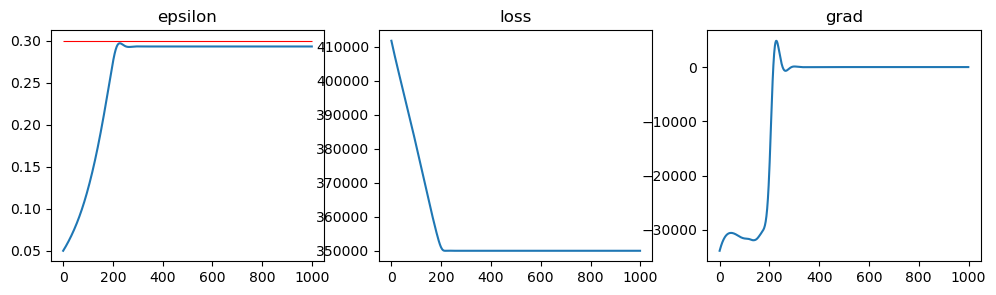

In [6]:
est_bc.print_history(history, epsilon)

In [69]:
N_list = np.logspace(2, 4, 6, dtype = int)
T_list = np.logspace(2, 5, 6, dtype = int)
edge_per_t_list = [1, 5, 10]
rhos = np.logspace(1, 3, 10, dtype = int)

In [41]:
histories_df = repeat_estimations(N_list,T_list,edge_per_t_list,rhos,scipy = True, 
                                  print_progress = True, repetitions = 5, 
                                  min_delta = 10e-4, patience = 10, num_epochs = 5000)

Tot simulations 5400


3658it [5:06:25,  4.08s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [53]:
#histories_df.to_csv("../data/torch_optimization_BC_model_experiments_230223.csv")

In [7]:
histories_df = pd.read_csv("../data/torch_optimization_BC_model_experiments_230223.csv", index_col = 0)

In [8]:
histories_df.columns

Index(['real_epsilon', 'epsilon0', 'epsilon_torch', 'epsilon_scipy', 'mu',
       'rho', 'N', 'T', 'edge_per_t', 'epochs', 'time', 'distance_torch_real',
       'distance_scipy_real'],
      dtype='object')

<AxesSubplot:xlabel='real_epsilon', ylabel='epsilon_torch'>

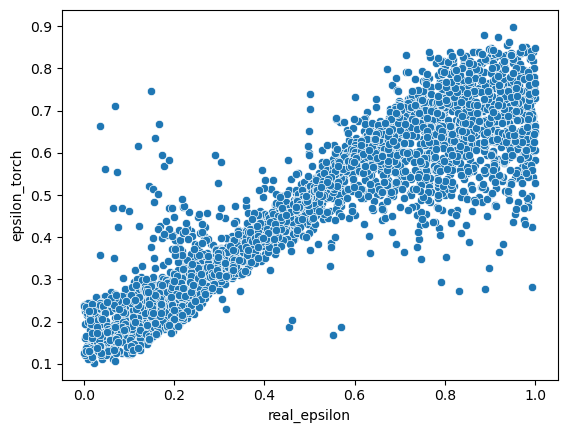

In [9]:
sns.scatterplot(data = histories_df.query("epochs > 50"), x = "real_epsilon", y = "epsilon_torch")

<AxesSubplot:xlabel='distance_torch_real', ylabel='epochs'>

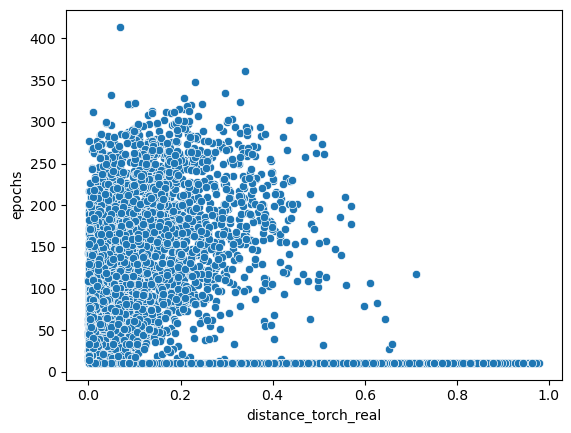

In [10]:
sns.scatterplot(data = histories_df, x = "distance_torch_real", y = "epochs")

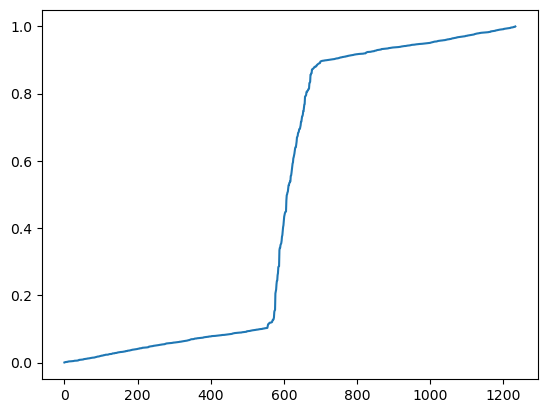

In [11]:
plt.plot(sorted(histories_df.query("epochs < 20")["epsilon0"]))

In [12]:
histories_df.sort_values("distance_scipy_real", ascending= False) \
.query("(rho > 20)&(rho < 1000) & (T > 100) & (epsilon0 > 0.3) & (real_epsilon < 0.7) & (epsilon0 < 0.7)").head(50)



,real_epsilon,epsilon0,epsilon_torch,epsilon_scipy,mu,rho,N,T,edge_per_t,epochs,time,distance_torch_real,distance_scipy_real
5115,0.584295,0.351858,0.579817,1.000000,0.643981,359,100,6309,5,123,0.115660,0.004478,0.415705
5152,0.590960,0.320944,0.567599,1.000000,0.480083,359,100,25118,10,135,0.214483,0.023361,0.409040
4112,0.612269,0.390552,0.596042,1.000000,0.672569,599,251,1584,1,106,0.041010,0.016227,0.387731
5201,0.676051,0.333586,0.650752,1.000000,0.464249,599,630,100000,1,193,0.234263,0.025300,0.323949
4034,0.682407,0.437348,0.658135,1.000000,0.952583,359,100,1584,5,116,0.069989,0.024272,0.317593
5120,0.682842,0.416821,0.657148,1.000000,0.214156,359,251,1584,5,139,0.064369,0.025694,0.317158
2991,0.691778,0.369463,0.530853,1.000000,0.512954,359,100,6309,10,98,0.112149,0.160924,0.308222
5259,0.622013,0.305610,0.568736,0.896146,0.635209,599,100,6309,10,130,0.167772,0.053277,0.274133
685,0.681559,0.678340,0.702125,0.720184,0.681059,215,100,398,5,22,0.008411,0.020566,0.038625
1372,0.612886,0.508612,0.621833,0.648248,0.821043,27,100,25118,10,67,0.131063,0.008947,0.035362


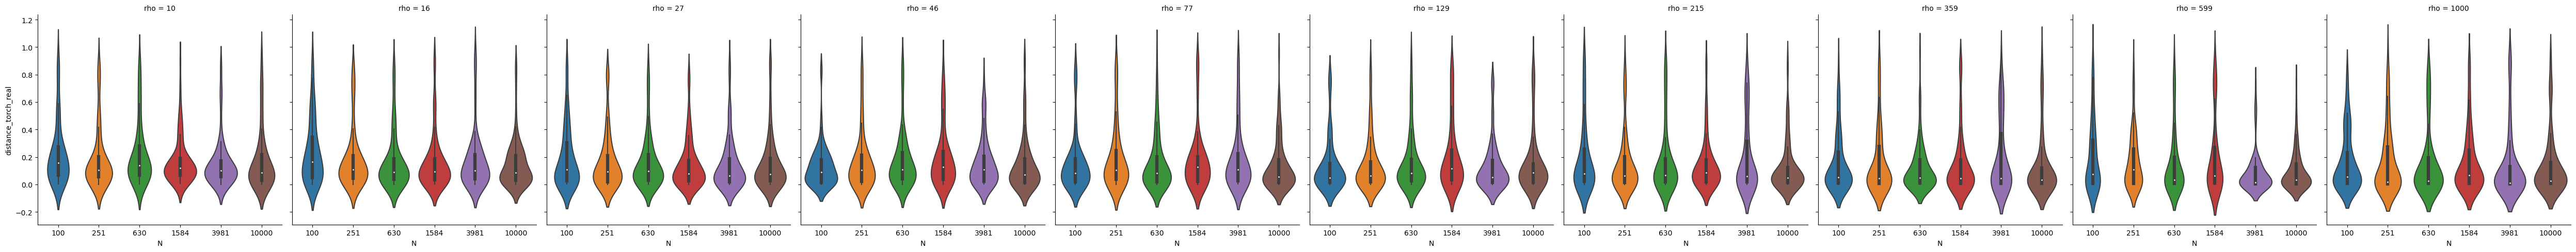

In [13]:
sns.catplot(data = histories_df, col = "rho", x = "N", y = "distance_torch_real", kind = "violin")


In [67]:
min_delta = 1e-5
patience = 20
num_epochs = 150

In [124]:
for _ in range(100):
    print(_)
    
    while True:
        epsilon, mu, epsilon0 = np.random.random(size = 3)
        if np.abs(epsilon - epsilon0) > 0.8:
            break
        
    N,T,edge_per_t,rho = [np.random.choice(L) for L in (N_list,T_list,edge_per_t_list[:-1],[1000])]
    
    X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, epsilon, mu, rho)
    
    history_torch = est_bc.estimation_epsilon_torch(rho, mu, X, edges, 
                                                    epsilon0, batch_size = 0, bce = nn.BCELoss(reduction = "sum"),
                                                    min_delta = min_delta, patience = patience, 
                                                    num_epochs = num_epochs,
                                                    hide_progress = True)
    if (len(history_torch["epsilon"]) < 149)&(np.abs(history_torch["epsilon"][-1] - epsilon) > 5e-2):
        break

0
1
2
3
4
5
6
7
8
9
10
11
12


In [144]:
print("rho", rho)
print("N", N)
print("edges", T * edge_per_t)
print("epsilon0", epsilon0)
print("epsilon torch", history_torch["epsilon"][-1])
print("real epsilon", epsilon)
print("Early stop", len(history_torch["epsilon"]))

rho 1000
N 10000
edges 100
epsilon0 0.851827296912432
epsilon torch 0.8411374714836869
real epsilon 0.045324182524414613
Early stop 122


In [126]:
u,v,s,t = sim_bc.convert_edges_uvst(edges)

In [140]:
history = est_bc.estimation_epsilon_torch(rho, mu, X, edges, 
                                          epsilon0, batch_size = 0,
                                          min_delta = min_delta, patience = patience, num_epochs = 1000,
                                          hide_progress = True)

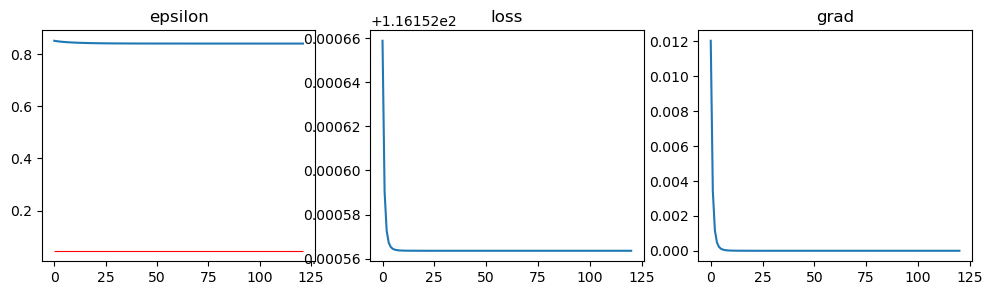

In [141]:
est_bc.print_history(history, epsilon)

In [142]:
losses_list = list(est_bc.losses_closure(edges, X, 1000, epsilon_values = np.arange(0,1,0.001), loss = nn.BCEWithLogitsLoss(reduction="sum"))[1])

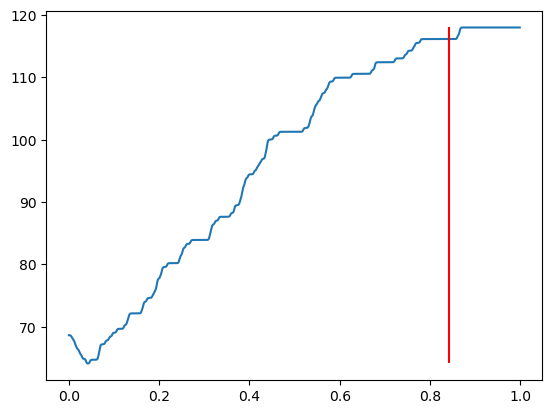

In [143]:
plt.plot(list(np.arange(0,1,0.001)), losses_list)
plt.vlines(x = history_torch["epsilon"][-1],
    #x = est_bc.estimation_epsilon_scipy(rho, X, edges, epsilon0), 
           ymin = min(losses_list),
           ymax = max(losses_list), colors = "red")

In [453]:
N_list = np.logspace(2.5, 4.5, 5, dtype = int)
T_list = np.logspace(2.5, 4.5, 5, dtype = int)
edge_per_t_list = [1, 5, 10]
rhos = np.logspace(1.4, 2.8, 10, dtype = int)

In [ ]:
histories_df2 = repeat_estimations(N_list,T_list,edge_per_t_list,rhos,scipy = True, 
                                   print_progress = True, repetitions = 5, 
                                   min_delta = 1e-4, patience = 10, num_epochs = 5000)

Tot simulations 3750
Simulation 1
Simulation 2
Simulation 3
Simulation 4
Simulation 5
Simulation 6
Simulation 7
Simulation 8
Simulation 9
Simulation 10
Simulation 11
Simulation 12
Simulation 13
Simulation 14
Simulation 15
Simulation 16
Simulation 17
Simulation 18
Simulation 19
Simulation 20
Simulation 21
Simulation 22
Simulation 23
Simulation 24
Simulation 25
Simulation 26
Simulation 27
Simulation 28
Simulation 29
Simulation 30
Simulation 31
Simulation 32
Simulation 33
Simulation 34
Simulation 35
Simulation 36
Simulation 37
Simulation 38
Simulation 39
Simulation 40
Simulation 41
Simulation 42
Simulation 43
Simulation 44
Simulation 45


In [ ]:
histories_df2.to_csv("../data/torch_optimization_BC_model_experiments_230224.csv")

In [48]:
histories_df = pd.read_csv("../data/torch_optimization_BC_model_experiments_230224.csv", index_col = 0)
histories_df = histories_df.assign(tot_edges = lambda x: x["T"] * x["edge_per_t"])

In [154]:
histories_df["tot_edges"].value_counts().index

Int64Index([ 10000,    316,   1000,   3162,  31622,   1580,   5000,  15810,
             50000, 158110,   3160,  31620, 100000, 316220],
           dtype='int64')

<AxesSubplot:xlabel='real_epsilon', ylabel='epsilon_torch'>

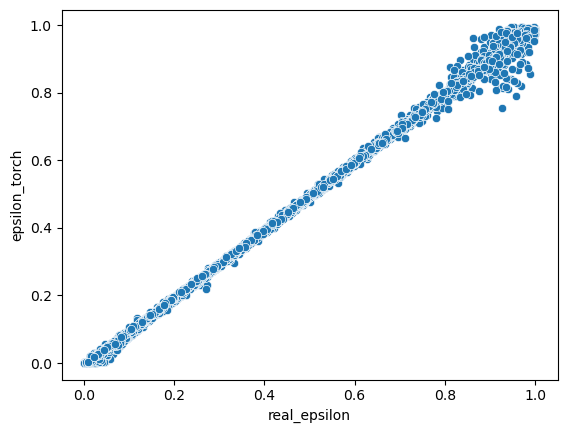

In [49]:
sns.scatterplot(data = histories_df, x = "real_epsilon", y = "epsilon_torch")

<AxesSubplot:xlabel='rho', ylabel='N'>

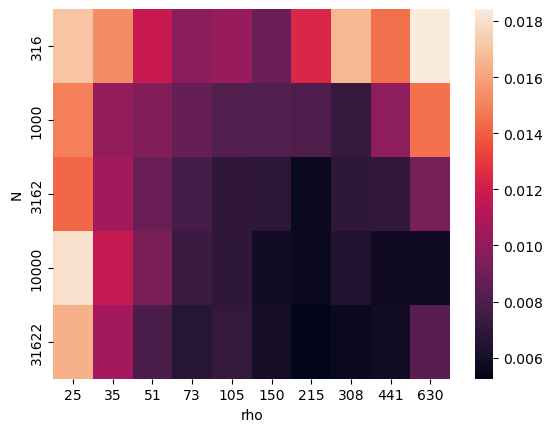

In [45]:
sns.heatmap(histories_df.groupby(["N", "rho"]).mean()["distance_torch_real"].unstack())

<AxesSubplot:xlabel='rho', ylabel='tot_edges'>

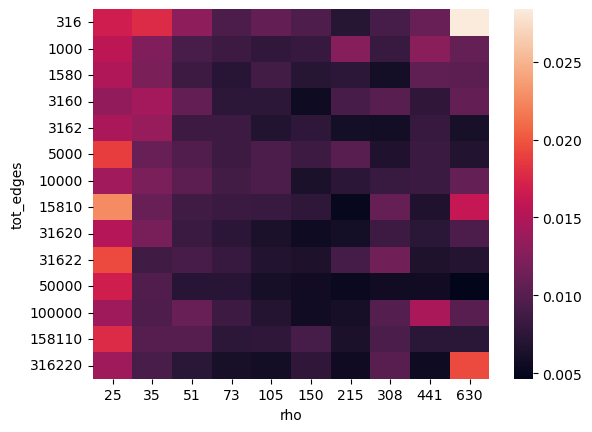

In [51]:
sns.heatmap(histories_df.groupby(["tot_edges", "rho"]).mean()["distance_torch_real"].unstack())

In [56]:
histories_df["distance_scipy_real"].mean(), histories_df["distance_torch_real"].mean()

(0.0193971975380296, 0.009600601526893323)

In [156]:
histories_df.sort_values("distance_torch_real", ascending = False).query("(real_epsilon < 0.7)&(rho > 99)").head(20)

,real_epsilon,epsilon0,epsilon_torch,epsilon_scipy,mu,rho,N,T,edge_per_t,epochs,time,distance_torch_real,distance_scipy_real,tot_edges
2952,0.696485,0.417570,0.670122,1.000000,0.688265,630,316,3162,5,5001,2.953742,0.026363,0.303515,15810
552,0.627099,0.541307,0.603867,0.603867,0.513796,308,316,3162,5,5001,3.065658,0.023231,0.023231,15810
1827,0.668262,0.506486,0.647501,0.647501,0.735683,105,316,3162,5,5001,3.055176,0.020762,0.020762,15810
2077,0.695318,0.563910,0.674691,0.703451,0.709858,308,316,3162,10,5001,23.646943,0.020627,0.008132,31620
1285,0.185853,0.598028,0.165389,0.165389,0.490209,308,3162,316,1,5001,1.496229,0.020464,0.020464,316
2879,0.542933,0.532703,0.523786,0.523786,0.203504,441,316,31622,5,5001,77.348995,0.019146,0.019146,158110
2030,0.619090,0.621075,0.636394,0.636394,0.411739,308,1000,316,1,5001,1.516744,0.017304,0.017304,316
2785,0.251957,0.362378,0.234756,0.234756,0.348196,308,3162,316,1,5001,1.519204,0.017202,0.017202,316
1281,0.405990,0.418375,0.389187,0.389187,0.300222,308,1000,1000,1,5001,1.631842,0.016803,0.016803,1000
3540,0.696521,0.445867,0.679809,0.679809,0.569713,308,10000,316,1,5001,1.522082,0.016712,0.016712,316


In [60]:
histories_df["epochs"].min()

5001

In [62]:
histories_df.sort_values("time", ascending = False).head(20)

,real_epsilon,epsilon0,epsilon_torch,epsilon_scipy,mu,rho,N,T,edge_per_t,epochs,time,distance_torch_real,distance_scipy_real,tot_edges
2223,0.883707,0.449198,0.881447,0.881447,0.541771,630,31622,10000,5,5001,111.545216,0.002260,0.002260,50000
3108,0.371755,0.520406,0.361168,0.361168,0.900447,35,1000,10000,5,5001,111.059362,0.010587,0.010587,50000
2883,0.935613,0.581813,0.939545,1.000000,0.499242,441,1000,10000,5,5001,111.032415,0.003932,0.064387,50000
2288,0.325666,0.579099,0.315670,0.315670,0.407550,25,3162,10000,5,5001,110.930453,0.009996,0.009996,50000
3103,0.838293,0.370131,0.831112,0.831112,0.654716,35,316,10000,5,5001,110.899534,0.007181,0.007181,50000
2368,0.919676,0.488735,0.946913,0.948024,0.088112,35,10000,10000,5,5001,110.888027,0.027237,0.028348,50000
2803,0.186074,0.506524,0.181526,0.181526,0.208410,308,316,10000,5,5001,110.824850,0.004548,0.004548,50000
2138,0.768644,0.356618,0.761935,0.761935,0.827872,441,3162,10000,5,5001,110.724603,0.006709,0.006709,50000
3408,0.743940,0.583994,0.737887,0.737887,0.001556,150,1000,10000,5,5001,110.707783,0.006053,0.006053,50000
2878,0.875503,0.657717,0.888381,1.000000,0.410407,441,316,10000,5,5001,110.650629,0.012878,0.124497,50000


<AxesSubplot:xlabel='distance_torch_real', ylabel='Density'>

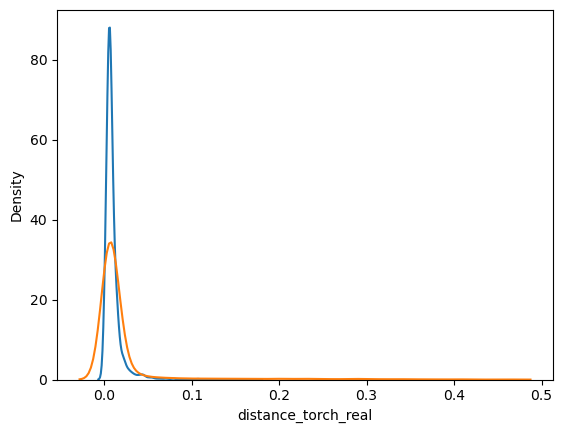

In [66]:
sns.kdeplot(histories_df["distance_torch_real"])
sns.kdeplot(histories_df["distance_scipy_real"])

In [169]:
X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, 0.3, mu, 100)
    

In [170]:
u,v,s,t = sim_bc.convert_edges_uvst(edges)

In [175]:
len(edges)

99

In [177]:
max(np.abs(X[t,u] - X[t,v]))

tensor(0.9129, dtype=torch.float64)

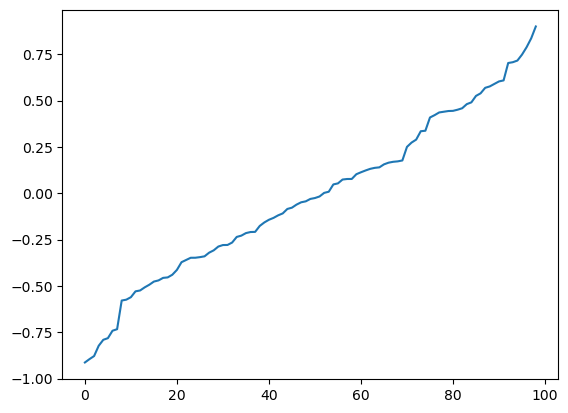

In [174]:
plt.plot(sorted(X[t,u] - X[t,v]))

<AxesSubplot:ylabel='Density'>

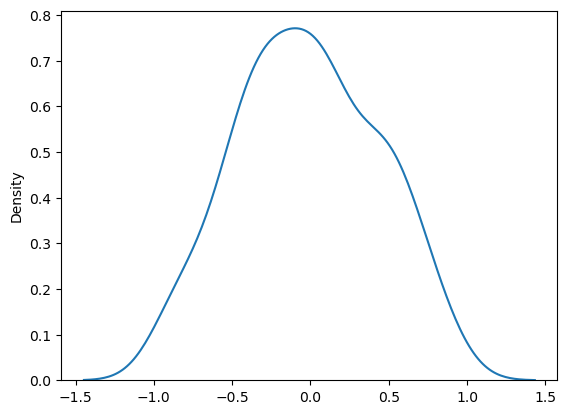

In [178]:
sns.kdeplot(X[t,u] - X[t,v])

In [188]:
sorted(np.abs(X[t,u] - X[t,v])), sorted(1-torch.sigmoid(100 * (0.3 - np.abs(X[t,u] - X[t,v]))))

([tensor(0.0020, dtype=torch.float64),
  tensor(0.0082, dtype=torch.float64),
  tensor(0.0173, dtype=torch.float64),
  tensor(0.0258, dtype=torch.float64),
  tensor(0.0306, dtype=torch.float64),
  tensor(0.0436, dtype=torch.float64),
  tensor(0.0476, dtype=torch.float64),
  tensor(0.0487, dtype=torch.float64),
  tensor(0.0533, dtype=torch.float64),
  tensor(0.0612, dtype=torch.float64),
  tensor(0.0740, dtype=torch.float64),
  tensor(0.0769, dtype=torch.float64),
  tensor(0.0771, dtype=torch.float64),
  tensor(0.0778, dtype=torch.float64),
  tensor(0.0847, dtype=torch.float64),
  tensor(0.1027, dtype=torch.float64),
  tensor(0.1087, dtype=torch.float64),
  tensor(0.1132, dtype=torch.float64),
  tensor(0.1191, dtype=torch.float64),
  tensor(0.1229, dtype=torch.float64),
  tensor(0.1316, dtype=torch.float64),
  tensor(0.1328, dtype=torch.float64),
  tensor(0.1371, dtype=torch.float64),
  tensor(0.1398, dtype=torch.float64),
  tensor(0.1430, dtype=torch.float64),
  tensor(0.1559, dtype=to

In [191]:
sorted(torch.sigmoid(100 * (0.3 - np.abs(X[t,u] - X[t,v]))))[-1].item()

0.9999999999998856